In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler

W1021 09:48:57.396619 199336 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1021 09:48:57.484620 199336 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 30
image_size = (32,32)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign',
                             transform=data_transform)

# split into train and test dataset
train_split = 0.8
dataset_size = len(trafficsign) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(train_indices),
                                              **kwargs)

test_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(test_indices),
                                              **kwargs)

# Load backdoor dataset

In [1]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign_backdoors',
                             transform=data_transform)

# shorten for testing reasons
size = len(backdoored) #set backdoor percentage
indices = list(range(size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
usedIndices = indices[:size]

backdoored.classes = '001' #<-- set all backdoors to a specific (wrong) class

dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(usedIndices),
                                              **kwargs)

NameError: name 'datasets' is not defined

# Visualize some training data

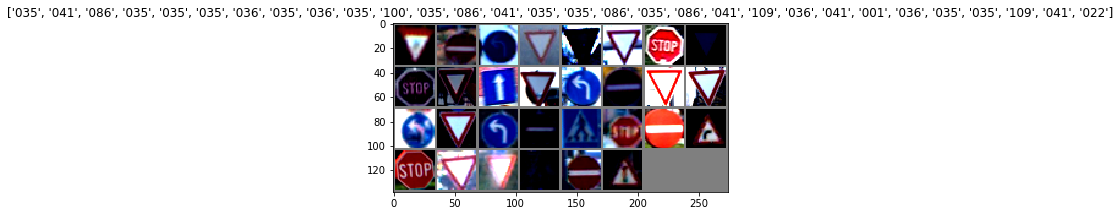

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Send dataset to clients

In [7]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
#for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
#            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
#            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
#            train_distributed_dataset_backdoor.append((data_append, target_append))
#            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

# Training Function

In [8]:
def train(epoch):
    #backdoor training in the beginning
#    for batch_idx, (data,target) in enumerate(train_distributed_dataset_backdoor):        
#        model.send(data.location) # 0) send the model to the right location
#        data, target = data.to(device), target.to(device)
#        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
#        #import pdb; pdb.set_trace()
#        output = model(data)  # 2) make a prediction
#        loss = F.nll_loss(output, target) # 3) calculate how much we missed
#        loss.backward() # 4) figure out which weights caused us to miss
#        optimizer.step() # 5) change those weights
#        model.get() # 6) get model (with gradients)
#            
#        #if batch_idx % 100 == 0:
#        loss = loss.get() # <-- NEW: get the loss back
#        print('BACKDOOR: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * batch_size, len(train_distributed_dataset_backdoor) * batch_size,
#                100. * batch_idx / len(train_distributed_dataset_backdoor), loss.item()))
    
    #normal training
    for batch_idx, (data,target) in enumerate(train_distributed_dataset):        
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset) * batch_size,
                100. * batch_idx / len(train_distributed_dataset), loss.item()))

# Test Function

In [25]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_indices)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_indices),
        100. * correct / len(test_indices)))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    # print(confusion_matrix.diag()/confusion_matrix.sum(1)) per class accuracy

# Run everyting

In [29]:
model = Net().to(device)

# stopped at:
model.load_state_dict(torch.load("traffic_paperCNN_32x32_19.pt"))

optimizer = optim.SGD(model.parameters(), lr=0.01)

#RUN training
for epoch in range(20, 21):
    train(epoch)
    torch.save(model.state_dict(), ("traffic_paperCNN_32x32_" + str(epoch) + ".pt"))
    test(model, device, test_loader)


Train Epoch: 20 [0/7890 (0%)]	Loss: 0.055292
Train Epoch: 20 [30/7890 (0%)]	Loss: 0.002086
Train Epoch: 20 [60/7890 (1%)]	Loss: 0.000604
Train Epoch: 20 [90/7890 (1%)]	Loss: 0.086865
Train Epoch: 20 [120/7890 (2%)]	Loss: 0.120181
Train Epoch: 20 [150/7890 (2%)]	Loss: 0.305156
Train Epoch: 20 [180/7890 (2%)]	Loss: 0.001059
Train Epoch: 20 [210/7890 (3%)]	Loss: 0.217068
Train Epoch: 20 [240/7890 (3%)]	Loss: 0.052660
Train Epoch: 20 [270/7890 (3%)]	Loss: 0.001205
Train Epoch: 20 [300/7890 (4%)]	Loss: 0.062671
Train Epoch: 20 [330/7890 (4%)]	Loss: 0.119715
Train Epoch: 20 [360/7890 (5%)]	Loss: 0.123981
Train Epoch: 20 [390/7890 (5%)]	Loss: 0.564420
Train Epoch: 20 [420/7890 (5%)]	Loss: 0.000747
Train Epoch: 20 [450/7890 (6%)]	Loss: 0.303182
Train Epoch: 20 [480/7890 (6%)]	Loss: 0.383912
Train Epoch: 20 [510/7890 (6%)]	Loss: 0.424896
Train Epoch: 20 [540/7890 (7%)]	Loss: 0.066871
Train Epoch: 20 [570/7890 (7%)]	Loss: 0.003433
Train Epoch: 20 [600/7890 (8%)]	Loss: 0.011924
Train Epoch: 20 [6

1967

In [26]:
model = Net().to(device)
model.load_state_dict(torch.load("traffic_paperCNN_32x32_15.pt"))
test(model, device, test_loader)



Test set: Average loss: 0.0435, Accuracy: 1944/1967 (99%)

tensor([[120.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2., 149.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  2.,   1., 559.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
        [  1.,   0.,   0., 242.,   1.,   0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0., 322.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,  41.,   0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,  76.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  84.,   0.,   4.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  41.,   1.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 310.]])
tensor([0.9917, 0.9803, 0.9911, 0.9878, 1.0000, 0.9762, 0.9620, 0.9545, 0.9762,
        0.9936])


tensor([[120.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2., 149.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  2.,   1., 559.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
        [  1.,   0.,   0., 242.,   1.,   0.,   0.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0., 322.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,  41.,   0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.,   0.,   0.,  76.,   1.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  84.,   0.,   4.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  41.,   1.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 310.]])
